In [1]:

import importlib
import proshestic_processor.prosthetic_hand_data_processor as prosthetic_hand_data_processor
importlib.reload(prosthetic_hand_data_processor)

from proshestic_processor.prosthetic_hand_data_processor import ProstheticHandDataProcessor

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.model_selection import cross_val_score


In [2]:
# Создаем df на базе считанных данных о файлах данных пилотов
pilot_files = pd.read_csv('./data/meta_information.csv')
# выбираем файлы для указанного пилота
pilote_id = 1
# создаем список файлов, котносящихся к указанному пилоту
palm_file = pilot_files[pilot_files.pilote_id == pilote_id].montage.apply(lambda x: './data/'+x).tolist()
# palm_file = './data/2023-06-05_16-12-38.palm'

In [4]:
# Создаем обьект на основе класса ProstheticHandDataProcessor
processor = ProstheticHandDataProcessor(
                              palm_file, # Список файлов с данными
                              pilote_id = pilote_id,# id пилота 
                              n_omg_channels=50, # количество каналов данных в файле
                              n_acc_channels=3, # количество каналов акселометра
                              n_gyr_channels=3, # количество каналов гироскопа
                              n_enc_channels=6, # количество кодированных каналов
                              n_mag_channels=0)

Всего файлов:                            7
Чтение файла значений:                   ./data/2023-05-15_16-16-08.palm
Чтение файла протокола жестов:           ./data/2023-05-15_16-16-08.palm
Количество записей:                      29145
Срезаем с и до:                          393 <> 29120
----------------------------------------------------------------------------------------------------
Чтение файла значений:                   ./data/2023-05-15_17-12-24.palm
Чтение файла протокола жестов:           ./data/2023-05-15_17-12-24.palm
Количество записей:                      29137
Срезаем с и до:                          395 <> 29109
----------------------------------------------------------------------------------------------------
Чтение файла значений:                   ./data/2023-06-05_16-12-38.palm
Чтение файла протокола жестов:           ./data/2023-06-05_16-12-38.palm
Количество записей:                      22368
Срезаем с и до:                          292 <> 22356
--------------

In [5]:
processor.vectors_cousine()

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 


In [6]:

processor.clean_sensor_getter_by_cosine(.99)
processor.median_sensor_power_getter()
processor.clean_sensor_getter_by_power(25)


Максимальная сила сигнала: 2397.0
Выбор сенсоров с сильным сигналом, доступны через <object>.CLEAN_SENSORS_FINAL 


['3',
 '6',
 '12',
 '13',
 '16',
 '17',
 '21',
 '22',
 '27',
 '28',
 '30',
 '31',
 '38',
 '39']

In [7]:
processor.get_vectors_final()
processor.get_df_final()

Создание словаря с векторами только для выбранных сенсоров в формате [сенсор][жест][шаг][значения],
 доступны через <object>.vectors_final 
Создание pd.DataFrame для выбранных сенсоров,
 доступны через <object>.gestures_clean
 


In [8]:
processor.get_neutral_vectors()
processor.get_vector_median_length()
processor.get_median_vectors()

Создание словаря с векторами для нейтроального положения, только для выбранных сенсоров
в формате [сенсор][жест][шаг][значения],доступны через <object>.vectors_neutral
 
Получаем медианную длину вектора для нейтрального положения, доступны через <object>.vector_median_length
 
Получаем словари с медианными длинами векторов, дисперсией
формат [sensor][жесть][медианный вектор]
Доступны через <object>.median_vectors_all, <object>.median_vectors_diff



In [9]:
# print(processor.median_vectors_all['39'][0])
# print(processor.vectors_neutral['39'][0][176])

In [10]:
# processor.get_min_max_for_senser()
# processor.vector_correction_all()

In [11]:
processor.create_additional_features_1()
processor.create_additional_features_1_vector()
processor.calculate_additional_features_1_cosine()


Создадим дополнительные признаки, путем ссумирования подряд по 5 сенсоров
Доступны через <object>.additional_features_1
 
Создадим векторы на базе additional_features_1 и интерполируем их
Доступны через <object>.additional_features_1_vector
 
Рассчитаем косинусную схожесть на векторе additional_features_1_vector
Доступны через <object>.additional_features_1_cosine_mean
 


In [12]:
# processor.plot_sensors(processor.additional_features_1.columns, range(processor.additional_features_1.shape[0]),'af1')

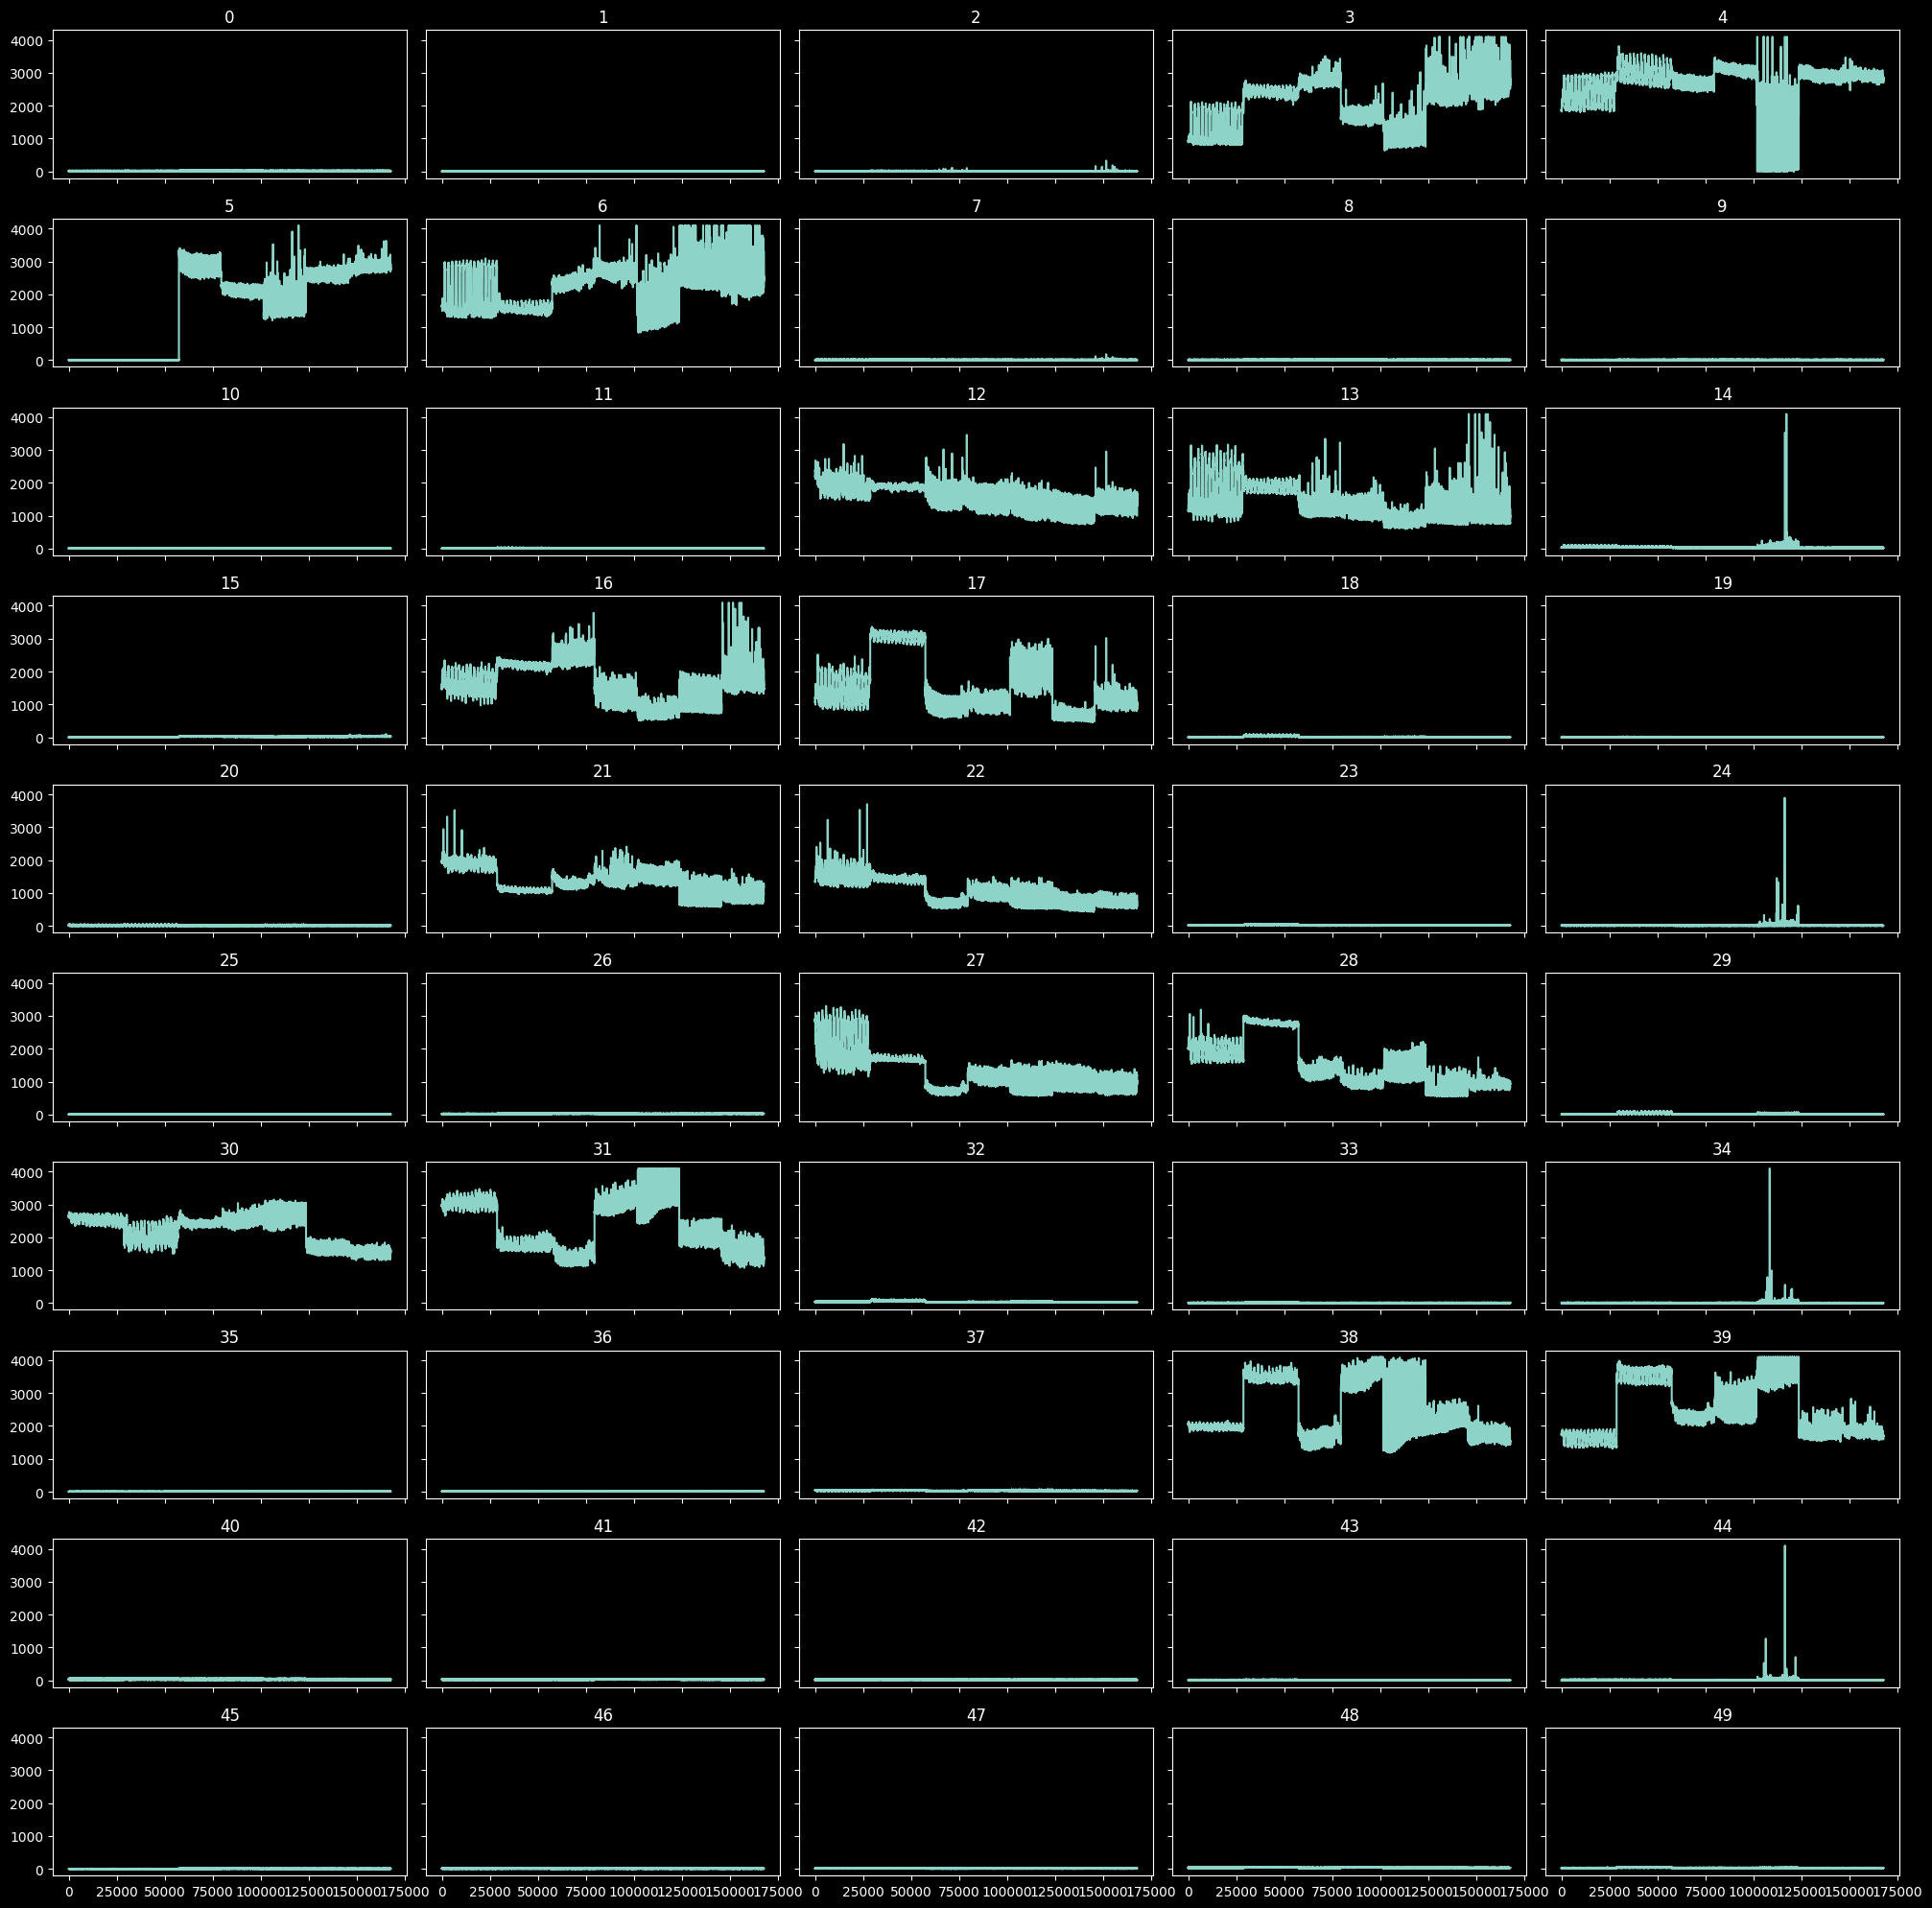

In [13]:
processor.plot_sensors(processor.OMG_CH, range(processor.gestures.shape[0]))
# processor.plot_sensors(processor.CLEAN_SENSORS_FINAL, range(processor.gestures.shape[0]),'hh')

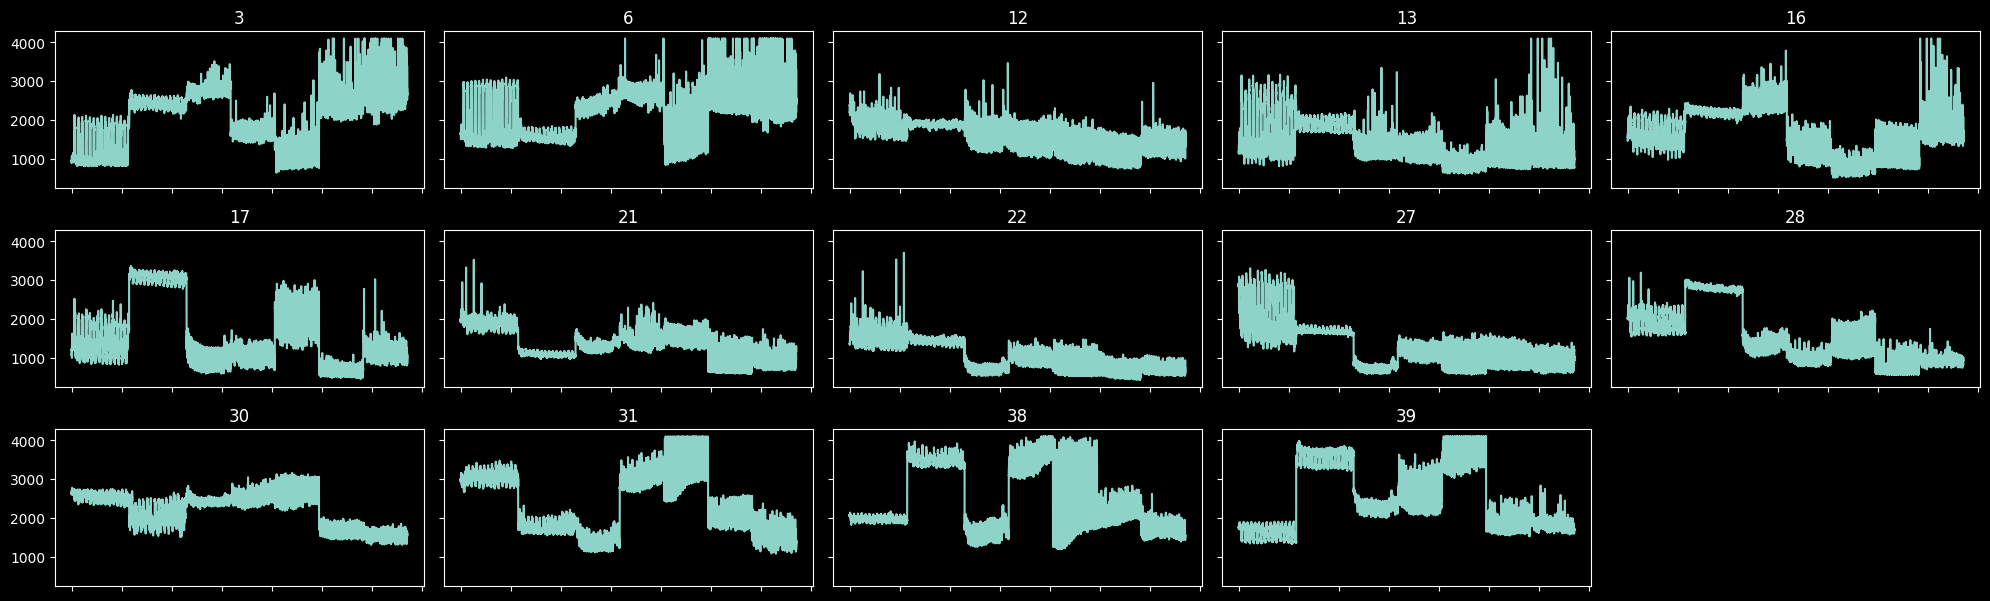

In [14]:

processor.plot_sensors(processor.CLEAN_SENSORS_FINAL, range(processor.gestures.shape[0]),'init')

In [15]:
# processor.plotly_sensor(0,'38','f')

In [16]:
# processor.clean_sensor_getter_by_cosine(.975)
# processor.median_sensor_power_getter()
# processor.clean_sensor_getter_by_power(25)
# print(processor.CLEAN_SENSORS_FINAL)
# processor.clean_sensor_getter_by_cosine_add_feat_1(.999)
# print(processor.CLEAN_SENSORS_ADD_FEATURE_1)
# processor.get_vectors_final()
# processor.get_df_final()

In [17]:

processor.cleaned_df_diff_adding()

In [18]:
processor.create_fix_gestures_df(shift = (-1,0))

Создаем таблицу смещения
Доступны через <object>.changes_df_info
 
Делаем смещение начало и конца жеста, согласно changes_df_info 


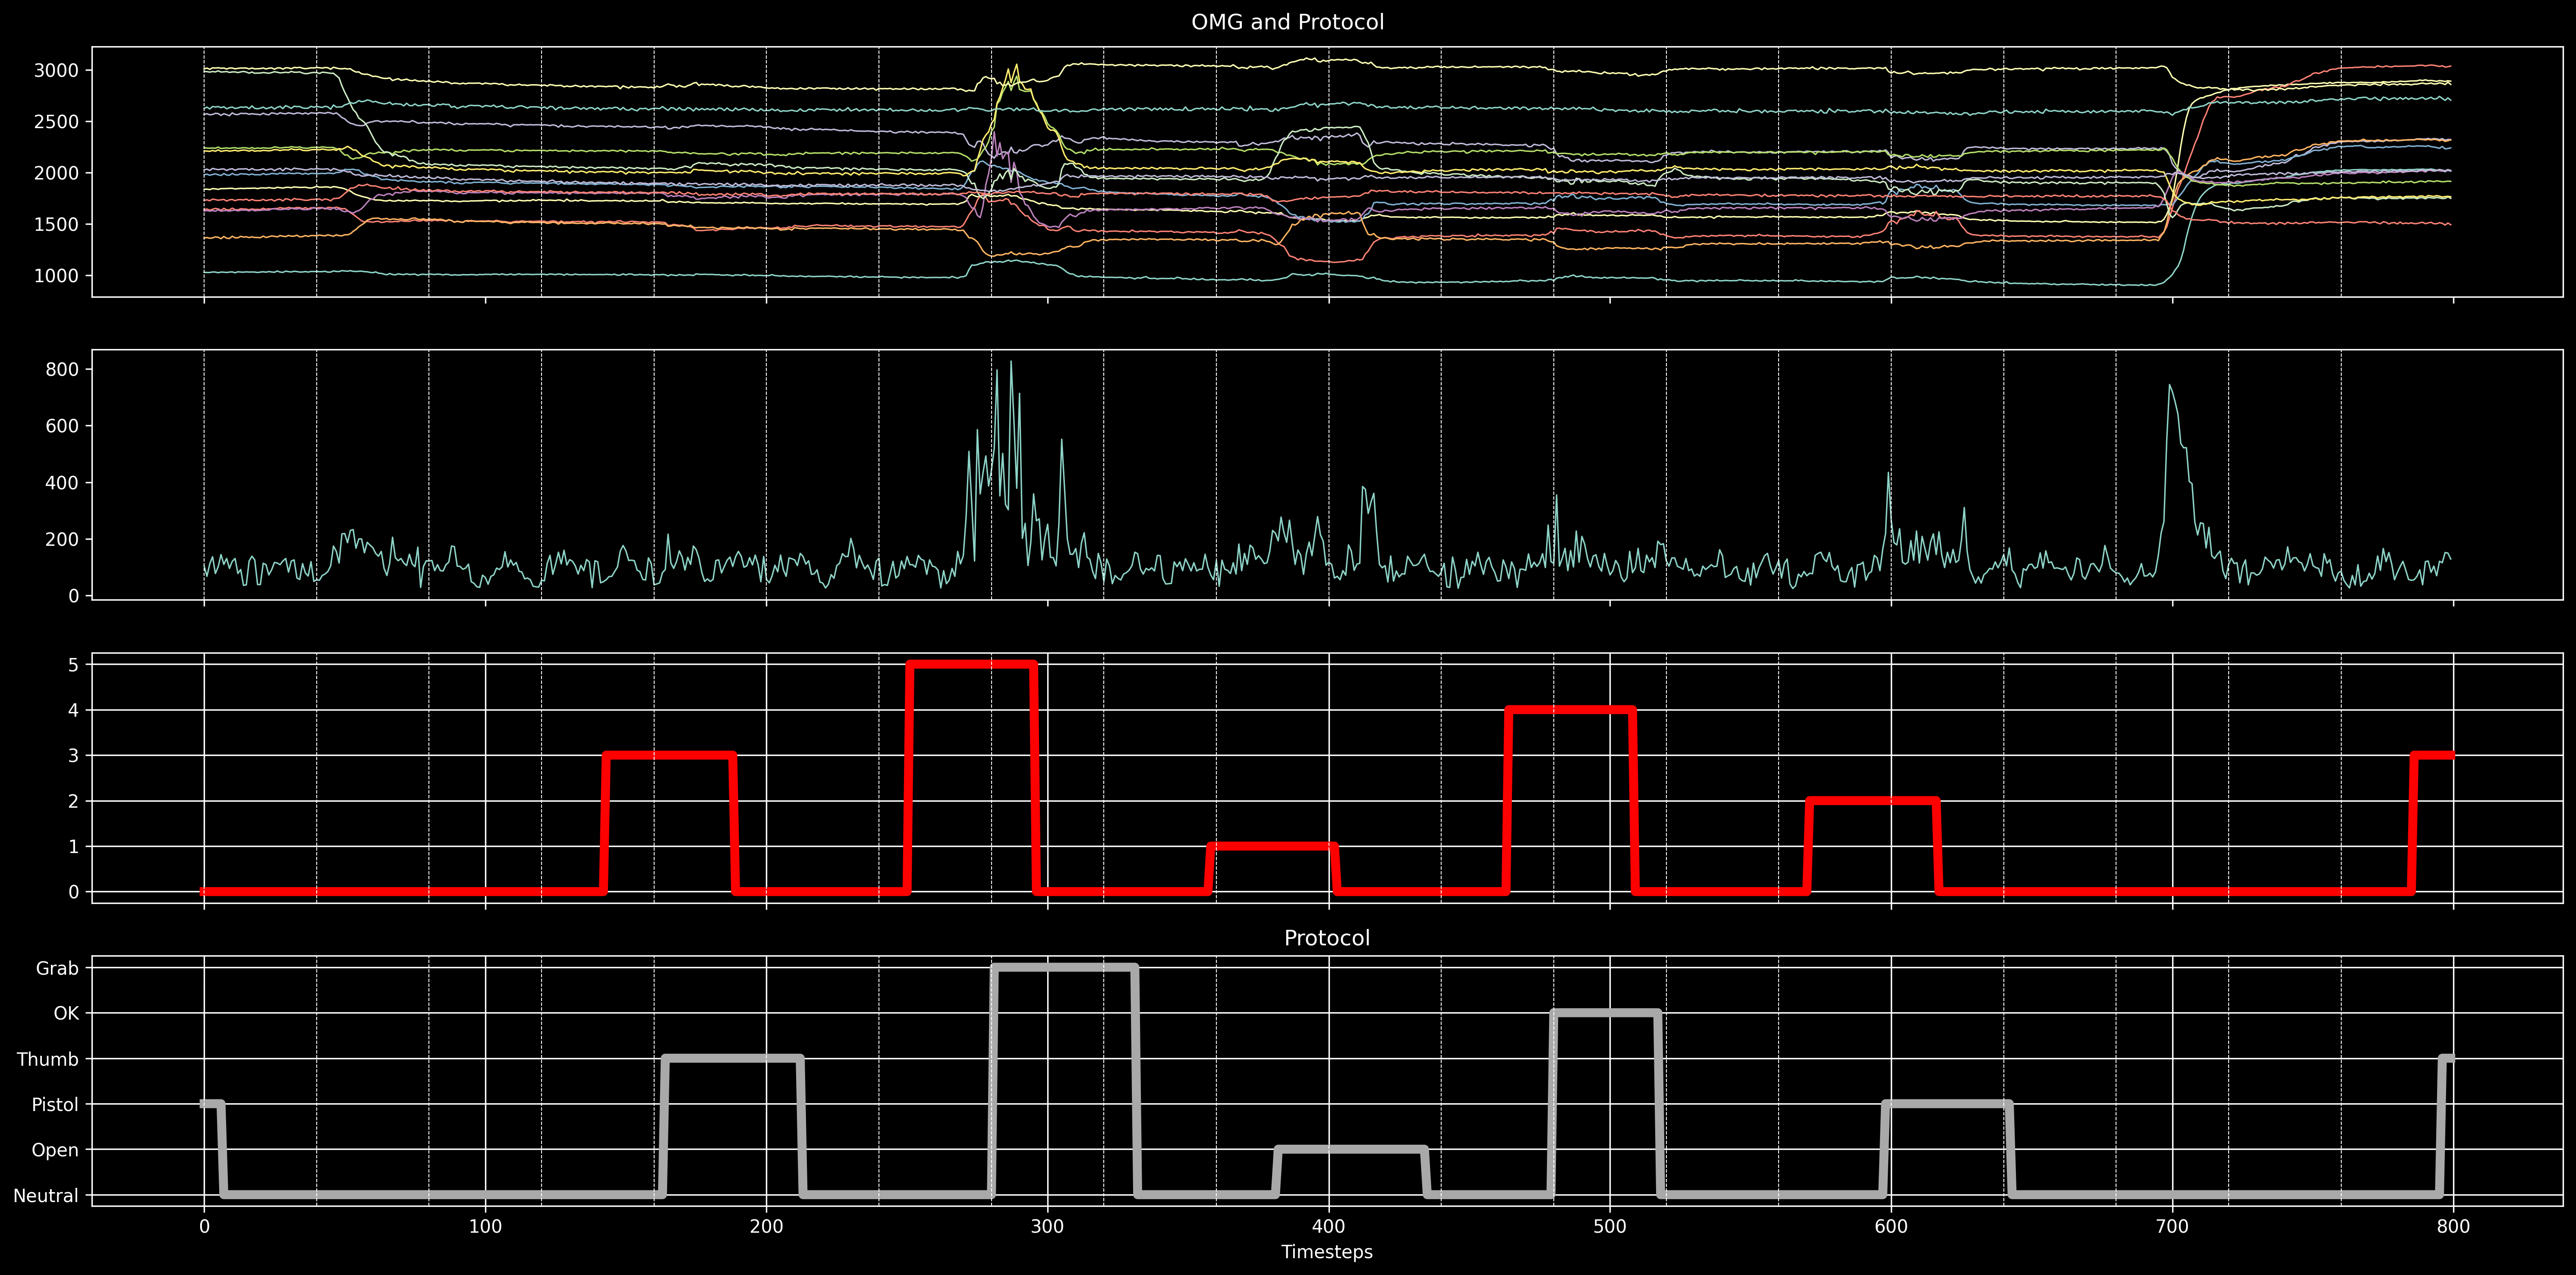

In [19]:
processor.graph_sensor_gestures(range(500, 1300),2)
# range_ = range(500, 1300)
# range_ = range(7400,8200)
# range_ = range(0,500)

In [20]:
steps = processor.get_cosine_steps(15)[:-3]
steps

[0.9120702121075993,
 0.9895843736520528,
 0.9950992339924574,
 0.9959380873967143,
 0.9965853410359988,
 0.9970840535654041,
 0.9970934715906201,
 0.9975525279710814,
 0.9980473819915122,
 0.9984021527609712,
 0.9985172446808954,
 0.9987593636118811]

In [ ]:
processor.vectors_cousine()
processor.change_params_and_apply(0.9935822256469482,25,.95,(0,0))

X,X_init,y = processor.model_data_prepare(True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
processor.change_params_and_apply(0.9935822256469482,25,.95,(0,0))

## Modeling

In [22]:
selection_params = {
    'cosine' : .98,
    'sensor_power' : 25,
    'cosine_add_feature_1' : .999,
    'shift' : (0,0)
}

lgb_params = {
    'n_estimators' : 1000,         # Количество деревьев
    'learning_rate' : 0.02,         # Скорость обучения
    'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
    'min_child_samples' : 20,      # Минимальное число образцов в листьях
    'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
    'random_state' : 42            # Для воспроизводимости
}

rf_params = {
    'n_estimators': 50,          # Количество деревьев
    'max_depth': 40,             # Ограничение глубины деревьев
    'min_samples_split': 5,      # Минимум 5 выборок для разделения
    'min_samples_leaf': 3,       # Минимум 3 выборки в листе
    'max_features': 'log2',      # Количество признаков для каждого разделения
    'random_state': 42
}

# lgb_params = {
#     'n_estimators' : 2000,         # Количество деревьев
#     'learning_rate' : 0.1,         # Скорость обучения
#     'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
#     'min_child_samples' : 20,      # Минимальное число образцов в листьях
#     'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
#     'random_state' : 42            # Для воспроизводимости
# }

# rf_params = {
#     'n_estimators': 100,          # Количество деревьев
#     'max_depth': 40,             # Ограничение глубины деревьев
#     'min_samples_split': 5,      # Минимум 5 выборок для разделения
#     'min_samples_leaf': 3,       # Минимум 3 выборки в листе
#     'max_features': 'log2',      # Количество признаков для каждого разделения
#     'random_state': 42
# }

In [23]:
for step in steps:
    selection_params['cosine'] = step
    processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=False, stat_file = 'st.json' )

for step in steps:
    selection_params['cosine'] = step
    processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=True, stat_file = 'st.json' )    

for step in steps:
    selection_params['cosine'] = step
    processor.fit_and_predict(pilote_id, 'lgb', lgb_params, selection_params, use_add=False, stat_file = 'st.json' )

for step in steps:
    selection_params['cosine'] = step
    processor.fit_and_predict(pilote_id, 'lgb', lgb_params, selection_params, use_add=True, stat_file = 'st.json' )    

Максимальная сила сигнала: 2851.0
['3', '4', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '16', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '21', '22', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_feature_8']
Новый объект добавлен успешно.
Максимальная сила сигнала: 2397.0
['3', '6', '12', '21', '27', '28', '30', '31', '38', '39']
['new_feature_7', 'new_

In [24]:
# processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=False, stat_file = 'st.json' )

In [54]:
processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)

{'lgb': {'min': 0.8300930759166666,
  'min_id': 113,
  'max': 0.9732316087611111,
  'max_id': 102},
 'rf': {'min': 0.8437497953518519,
  'min_id': 101,
  'max': 0.9510481419555555,
  'max_id': 91}}

In [55]:
processor.get_statistic_by_id(pd.read_json('st.json'),102)


precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.945     0.989      1.000     0.973     0.995   
Open         1.000     0.968     0.994      1.000     0.937     0.987   
Pistol       1.000     0.942     0.989      1.000     0.884     0.977   
Thumb        1.000     0.934     0.987      1.000     0.881     0.976   
OK           1.000     0.950     0.990      1.000     0.903     0.980   
Grab         1.000     0.958     0.992      1.000     0.921     0.985   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.959     0.992  
Open         1.000     0.952     0.991  
Pistol       1.000     0.912     0.983  
Thumb        1.000     0.907     0.982  
OK           1.000     0.926     0.985  
Grab         1.000     0.939     0.989

In [56]:
processor.get_statistic_by_id(pd.read_json('st.json'),91)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      0.978     0.914     0.965      0.998     0.977     0.993   
Open         0.994     0.960     0.987      0.974     0.906     0.960   
Pistol       0.997     0.943     0.987      0.953     0.810     0.925   
Thumb        0.997     0.951     0.989      0.964     0.812     0.933   
OK           0.995     0.946     0.986      0.961     0.838     0.936   
Grab         0.994     0.960     0.988      0.968     0.864     0.948   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      0.988     0.944     0.979  
Open         0.984     0.932     0.973  
Pistol       0.975     0.872     0.955  
Thumb        0.980     0.876     0.960  
OK           0.978     0.889     0.960  
Grab         0.981     0.909     0.968

In [28]:
stat = processor.get_stat('st.json')
print(processor.get_model_params_by_id(stat, 91))
print(processor.get_params_by_id(stat, 91))

{'rf': {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'random_state': 42}}
{'cosine': 0.9895843736520521, 'sensor_power': 25, 'cosine_add_feature_1': 0.999, 'use_add': True, 'shift': <bound method NDFrame.shift of cosine                   0.990
sensor_power                25
cosine_add_feature_1     0.999
use_add                   True
shift                   [0, 0]
features_num                14
features_add_1_num           2
Name: 91, dtype: object>, 'features_num': 14, 'features_add_1_num': 2}


In [29]:

# X,X_init,y =processor.model_data_prepare(True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [30]:
# model = RandomForestClassifier(**rf_params)
# model.fit(X = X_train, y=y_train)

In [31]:
# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

In [32]:
# processor.plot_results(y_train, y_pred_train, (20,4), .1)

In [33]:
# processor.plot_results(y_test, y_pred_test, (20,4), .2)

In [34]:
# processor.get_statistic(y_train, y_pred_train,1)


In [35]:
# processor.get_statistic(y_test, y_pred_test,2)

In [36]:
# y_pred_train_init = model.predict(X_init)


In [37]:
# processor.plot_results(y, y_pred_train_init, (20,4), 1)


In [38]:
# processor.get_statistic(y, y_pred_train_init,3)

In [39]:
# results = pd.DataFrame([y,y_pred_train_init]).transpose().rename(columns={0: 'train',1:'pred'})

In [40]:
# model_parameters = processor.get_params()
# model_parameters['rf_params'] = rf_params
# model_parameters['model'] = 'rf'
# processor.save_stat('stats.json', model_parameters)

In [41]:
stat = processor.get_stat('st.json')

In [42]:
stat.filter(regex='^(recall|f1|shift)').tail(7)


,shift,recall.Neutral,recall.Open,recall.Pistol,recall.Thumb,recall.OK,recall.Grab,f1-score.Neutral,f1-score.Open,f1-score.Pistol,f1-score.Thumb,f1-score.OK,f1-score.Grab
119,"[0, 0]",0.994,0.984,0.967,0.970,0.974,0.979,0.989,0.988,0.977,0.977,0.981,0.986
120,"[0, 0]",0.993,0.983,0.963,0.966,0.972,0.976,0.988,0.987,0.974,0.974,0.979,0.984
121,"[0, 0]",0.991,0.982,0.960,0.954,0.967,0.972,0.986,0.986,0.971,0.965,0.976,0.981
122,"[0, 0]",0.990,0.978,0.940,0.943,0.953,0.964,0.982,0.984,0.959,0.957,0.965,0.977
123,"[0, 0]",0.987,0.973,0.925,0.931,0.932,0.958,0.977,0.979,0.949,0.946,0.952,0.971
124,"[0, 0]",0.983,0.955,0.867,0.900,0.900,0.923,0.966,0.967,0.912,0.924,0.928,0.949
125,"[0, 0]",0.974,0.899,0.762,0.818,0.790,0.820,0.937,0.929,0.837,0.865,0.849,0.880


In [43]:
# processor.get_min_max_stat_for_pilote(pd.read_json('stats.json'),pilote_id)

In [44]:
processor.get_model_params_by_id(stat, 50)
processor.get_params_by_id(stat, 50)

{'cosine': 0.974332354473679,
 'sensor_power': 25,
 'cosine_add_feature_1': 0.999,
 'use_add': True,
 'shift': <bound method NDFrame.shift of cosine                   0.974
 sensor_power                25
 cosine_add_feature_1     0.999
 use_add                   True
 shift                   [0, 0]
 features_num                 9
 features_add_1_num           1
 Name: 50, dtype: object>,
 'features_num': 9,
 'features_add_1_num': 1}

In [45]:
# processor.get_params_by_id(stat, 16)

In [46]:
# processor.get_statistic_by_id(pd.read_json('st.json'),10)

In [47]:

# processor.get_statistic_by_id(pd.read_json('st.json'),16)

In [48]:
# model_params = {
#     'n_estimators' : 2000,         # Количество деревьев
#     'learning_rate' : 0.02,         # Скорость обучения
#     'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
#     'min_child_samples' : 20,      # Минимальное число образцов в листьях
#     'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
#     'random_state' : 42            # Для воспроизводимости
# }

# model_lgb = lgb.LGBMClassifier(**model_params)

# # Кросс-валидация
# cv_scores = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='accuracy')
# print(f'Средняя точность кросс-валидации: {np.mean(cv_scores):.4f}')

# # Обучение модели
# model_lgb.fit(X_train, y_train)

In [49]:
# model_parameters = processor.get_params()
# model_parameters['model_params'] = model_params
# model_parameters['model'] = 'lgb'
# processor.save_stat('stats.json', model_parameters)

In [50]:
# y_pred_train = model_lgb.predict(X_train)
# y_pred_test = model_lgb.predict(X_test)
# y_pred_train_init = model.predict(X_init)

In [51]:
# processor.get_statistic(y_train, y_pred_train,1)

In [52]:
# processor.get_statistic(y_test, y_pred_test,2)

In [53]:
# processor.get_statistic(y, y_pred_train_init,3)